# Quantum Support Vector Machine for Mixed State Classification

This notebook is a variation of `qsvm_haar_obs.ipynb`.
The main difference consists in the **used dataset**.

**For implementation details**, where not specified, **check the notebook `qsvm_haar_obs.ipynb`**.

## Differences

- In this dataset (`ds_mixed_obs.csv`) the observables are applied to a mixed quantum state (of the dataset `ds_mixed_dm.csv`).
- The features no longer have a uniform distribution, as such the svm model, **rescales** them.


In [2]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from qiskit.circuit.library import PauliFeatureMap
from qiskit import QuantumCircuit
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit_algorithms.state_fidelities import ComputeUncompute, BaseStateFidelity
from qiskit_machine_learning.kernels import FidelityQuantumKernel

from typing import Optional, Tuple
import time

# Dataset

In [3]:
# load dataset
df = pd.read_csv('../datasets/ds_mixed_obs.csv')
df.head()

,OBS_0,OBS_1,OBS_2,OBS_3,OBS_4,OBS_5,OBS_6,OBS_7,OBS_8,OBS_9,separable
0,0.268372,0.246112,0.320277,0.157779,0.255752,0.174061,0.301679,0.233190,0.208881,0.241814,False
1,0.241903,0.239770,0.258264,0.253273,0.243815,0.277775,0.223547,0.237721,0.237809,0.241504,False
2,0.185326,0.223879,0.240827,0.249868,0.232626,0.242109,0.246553,0.233927,0.234095,0.246902,True
3,0.233334,0.252164,0.278026,0.249751,0.236253,0.240901,0.245941,0.248044,0.280448,0.269990,False
4,0.234331,0.234900,0.250295,0.248989,0.247575,0.252747,0.250756,0.240557,0.257094,0.250061,True


## Distribution of the features

Features are not uniformly distributed, as such rescalig might be helpful.

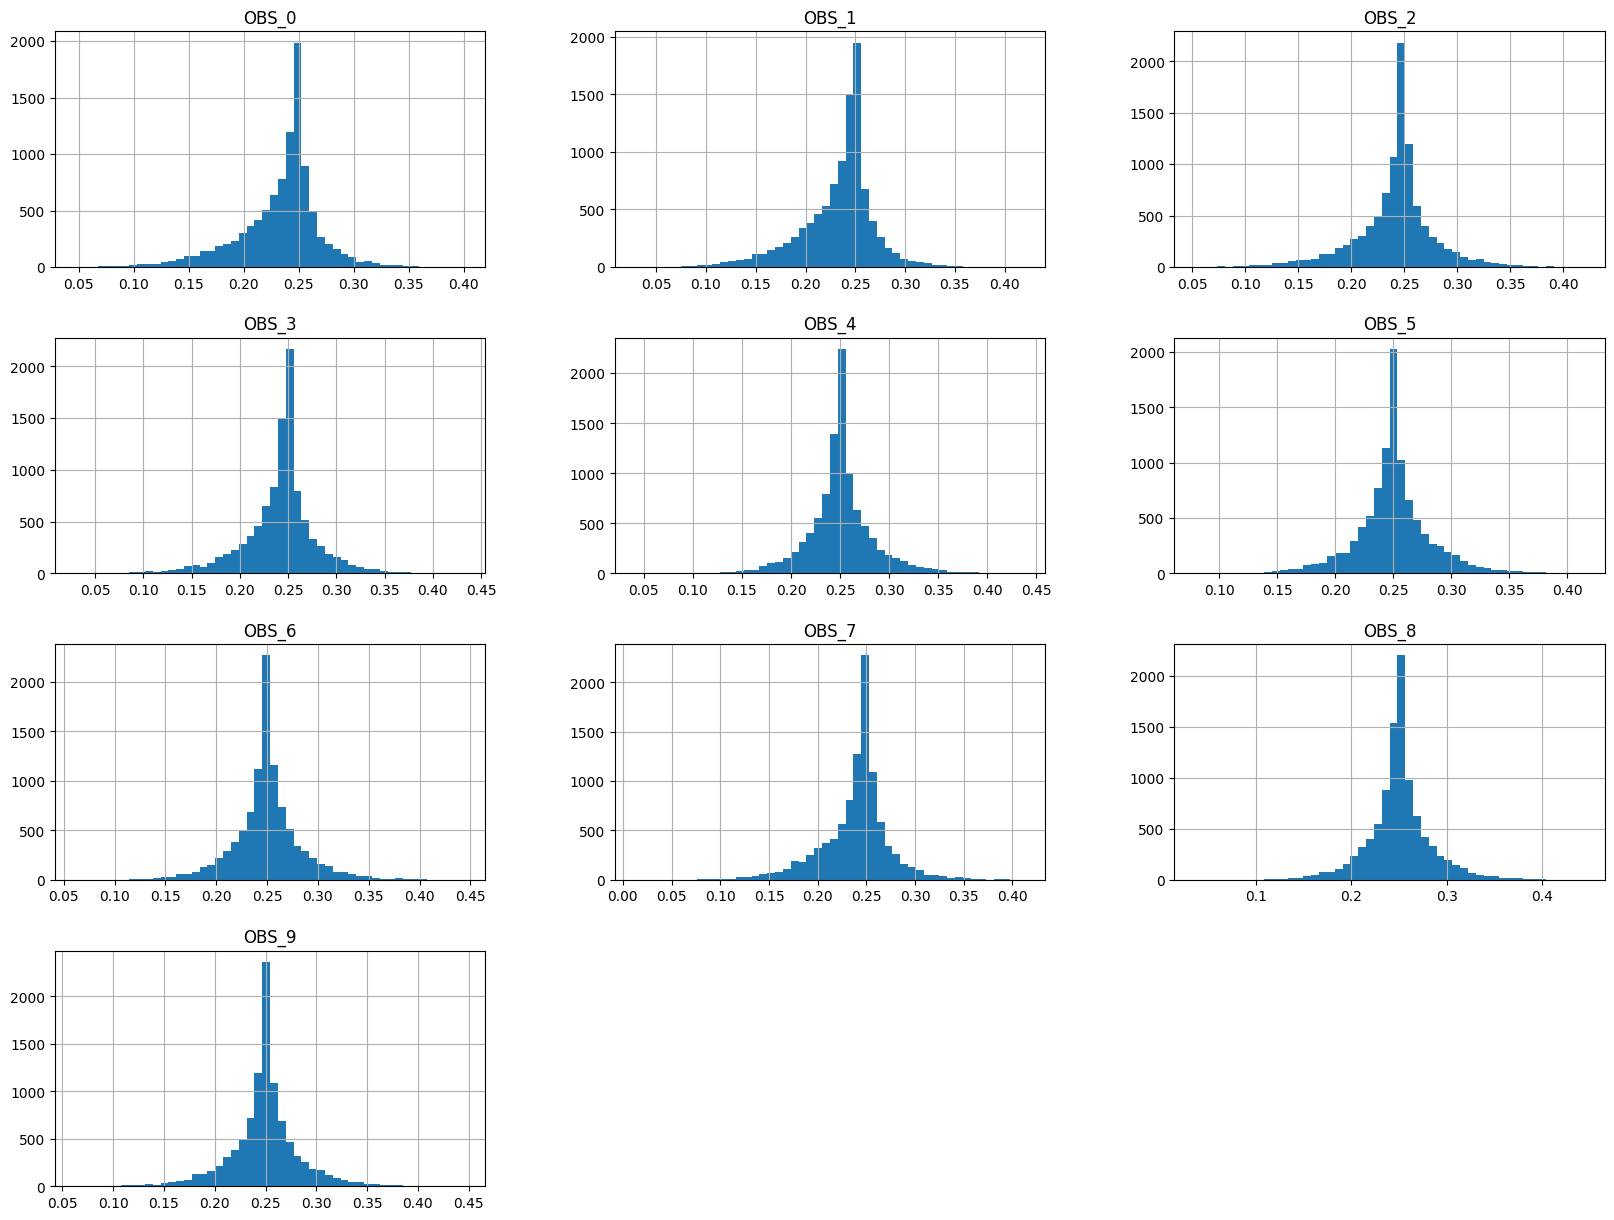

In [5]:
# split data
X = df.drop('separable', axis=1)
y = df['separable']

# X value distribution
X.hist(bins=50, figsize=(20,15))
plt.show()

In [6]:
# undersampling 
sampling_strategy = {0: 100, 1: 100}
undersample = RandomUnderSampler(sampling_strategy = sampling_strategy)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# print counts
print(f"sep/ent value counts: {y_resampled.value_counts()}")

sep/ent value counts: separable
False    100
True     100
Name: count, dtype: int64


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 160
Test size: 40


# model

In [9]:
from qsvm import manual_quantum_kernel, qiskit_quantum_kernel, sampler_quantum_kernel, get_feature_map, train_test

### Manual kernel

In [10]:
start = time.time()
model, score = train_test(X_train, y_train, X_test, y_test)
end = time.time()

print(f"Accuracy: {score}, time: {end - start}")

Accuracy: 0.825, time: 300.6926636695862


### Qiskit kernel

In [11]:
start = time.time()
model, score = train_test(X_train, y_train, X_test, y_test, kernel_function="qiskit")
end = time.time()

print(f"Accuracy: {score}, time: {end - start}")

Accuracy: 0.825, time: 724.4450166225433


### Sampler kernel

In [12]:
start = time.time()
model, score = train_test(X_train, y_train, X_test, y_test, kernel_function="sampler")
end = time.time()

print(f"Accuracy: {score}, time: {end - start}")

Accuracy: 0.475, time: 796.8662929534912


## Feature Reduction

In [13]:
times = []
accuracy = []
features = [10, 9, 8, 7, 6, 5, 4, 3, 2]

while len(X_train.columns) > 1:
    # train and test the model
    start = time.time()
    model, score = train_test(X_train, y_train, X_test, y_test)
    end = time.time()
    times.append(end - start)
    accuracy.append(score)
    print(f"Features: {len(X_train.columns)}, Accuracy: {score}, Time: {end - start}")
    
    # perform the feature reduction
    # Train a Logistic Regression model with L1 regularization
    lr_model = LogisticRegression(penalty='l1', solver='liblinear')
    lr_model.fit(X_train, y_train)
    
    # Extract coefficients assigned to each feature
    lr_coefficients = pd.Series(lr_model.coef_[0], index=X_train.columns)
    
    # Sort coefficients in descending order
    lr_coefficients_sorted = lr_coefficients.abs().sort_values(ascending=False)
    
    print(f"Removing feature: {lr_coefficients_sorted.index[-1]}")
    X_train = X_train.drop(lr_coefficients_sorted.index[-1], axis=1)
    X_test = X_test.drop(lr_coefficients_sorted.index[-1], axis=1)

Features: 10, Accuracy: 0.825, Time: 331.9116544723511
Removing feature: OBS_9
Features: 9, Accuracy: 0.775, Time: 282.7133276462555
Removing feature: OBS_8
Features: 8, Accuracy: 0.75, Time: 236.76403045654297
Removing feature: OBS_7
Features: 7, Accuracy: 0.75, Time: 202.61947655677795
Removing feature: OBS_6
Features: 6, Accuracy: 0.725, Time: 173.3701298236847
Removing feature: OBS_5
Features: 5, Accuracy: 0.75, Time: 166.8281545639038
Removing feature: OBS_4
Features: 4, Accuracy: 0.75, Time: 127.04336953163147
Removing feature: OBS_3
Features: 3, Accuracy: 0.725, Time: 88.74942469596863
Removing feature: OBS_2
Features: 2, Accuracy: 0.55, Time: 60.543190717697144
Removing feature: OBS_1


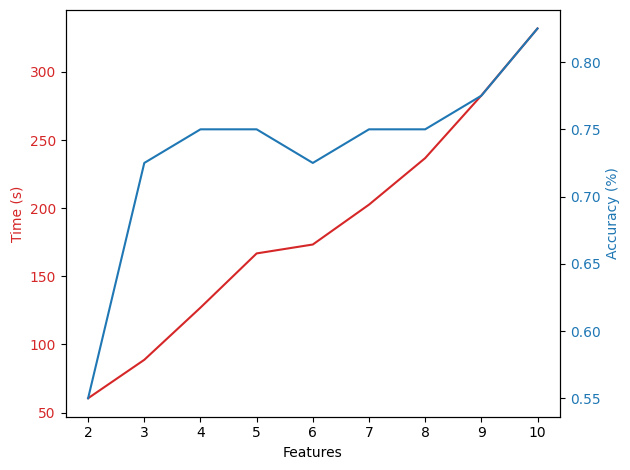

In [14]:
from qsvm import plot_results

plot_results(features, times, accuracy)